Reference:https://www.analyticsvidhya.com/blog/2021/12/multiclass-classification-using-transformers/#h2_5

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 63.5 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 6.6 MB 51.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from tensorflow.keras.utils import to_categorical
import transformers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [52]:
df = pd.read_csv("cleaned_Stackoverflow_data.csv")


In [53]:
df.shape


(34231, 3)

In [54]:
df.head()

,Title,Body,Tags
0,No display after getting all Id's using checkbox,hello guys please help solve happen suddenly l...,<php>
1,How to check if 30 minutes left for a business...,currently working project business open displa...,<php>
2,how to fix this error : Fatal error: Call to u...,like hash password entered user get errorerror...,<php>
3,PHP - trying to loop through a checkbox array,get code isnt working display results page che...,<php>
4,Shorten a string to allowed length,writing functionality string converts url slug...,<php>


In [55]:
df['Tags'].unique()

array(['<php>', '<java>', '<javascript>', '<python>'], dtype=object)

Converting our Sentiment column into Categorical data

In [56]:
encoded_dict = {'<javascript>':0,'<python>':1, '<php>':2, '<java>':3}
df['Tag Encoded'] = df['Tags'].map(encoded_dict)
df

,Title,Body,Tags,Tag Encoded
0,No display after getting all Id's using checkbox,hello guys please help solve happen suddenly l...,<php>,2
1,How to check if 30 minutes left for a business...,currently working project business open displa...,<php>,2
2,how to fix this error : Fatal error: Call to u...,like hash password entered user get errorerror...,<php>,2
3,PHP - trying to loop through a checkbox array,get code isnt working display results page che...,<php>,2
4,Shorten a string to allowed length,writing functionality string converts url slug...,<php>,2
...,...,...,...,...
34226,How to make Python 2.7 and Python 3.1 coexist ...,python installed desktop need python run cql i...,<python>,1
34227,ConcurrentModificationException exception with...,creating multithread chat server java user log...,<java>,3
34228,"Same syntax as : if, for, while",thought syntax could helpful function myfuncti...,<javascript>,0
34229,"python, repeat random.randint?",new python would like know make code repeat ra...,<python>,1


Train_Test Split Data

In [57]:
# Shuffle the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
df = df.sample(frac=1)

In [58]:
texts = df["Body"].values
labels = df[["Tag Encoded"]].values

X_train,X_test, y_train, y_test = train_test_split(texts,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(27384,) (6847,)
(27384, 1) (6847, 1)


converting our integer coded Tag column into categorical data(matrix)

In [59]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


Loading Model and Tokenizer from the transformers package 

In [60]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Input Data Modeling
Before training, we need to convert the input textual data into BERT’s input data format using a tokenizer.

Since we have loaded bert-base-cased, so tokenizer will also be Bert-base-cased.



In [14]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=68,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=68,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Hereafter data modelling, the tokenizer will return a dictionary (x_train) containing ‘Input_ids’, ‘attention_mask’ as key for their respective
data.

In [15]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']
x_test['input_ids']

<tf.Tensor: shape=(6847, 68), dtype=int32, numpy=
array([[  101,  3053,  1862, ...,     0,     0,     0],
       [  101,  3295,  2511, ...,  9699, 21706,   102],
       [  101,  2191,  3188, ..., 13791, 24713,   102],
       ...,
       [  101,  9221,  3798, ...,  3802,  1583,   102],
       [  101,  1682,  2866, ...,  8223,  9245,   102],
       [  101,  1543,  5127, ..., 16278,   181,   102]], dtype=int32)>

Model Building

In [19]:
max_len = 68
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(4,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [22]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('accuracy'),
# Compile the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer = optimizer,
    metrics=["accuracy"])

In [39]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=1,
   batch_size=36
)

Epoch 1/3
761/761 [==============================] - 436s 573ms/step - loss: 0.1700 - accuracy: 0.9402 - val_loss: 0.2567 - val_accuracy: 0.9054
Epoch 2/3
761/761 [==============================] - 436s 573ms/step - loss: 0.1524 - accuracy: 0.9467 - val_loss: 0.2613 - val_accuracy: 0.9051
Epoch 3/3
761/761 [==============================] - 436s 573ms/step - loss: 0.1395 - accuracy: 0.9521 - val_loss: 0.2674 - val_accuracy: 0.9058


Model Evaluation

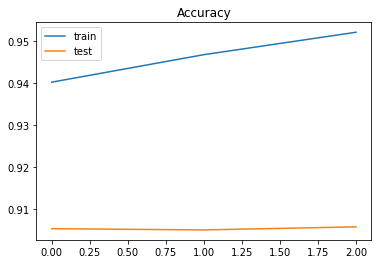

In [44]:
plt.title('Accuracy')
plt.plot(train_history.history['accuracy'], label='train')
plt.plot(train_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

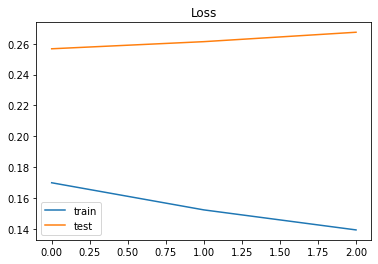

In [42]:
plt.title('Loss')
plt.plot(train_history.history['loss'], label='train')
plt.plot(train_history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [45]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

array([3.3156807e-03, 1.3635872e-03, 9.9488360e-01, 4.3718825e-04],
      dtype=float32)

In [46]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = np.argmax(y_test, axis=1)

In [48]:
print("Accuracy Score: "+str(accuracy_score(y_true, y_predicted) * 100))
print(classification_report(y_true, y_predicted))

Accuracy Score: 90.5798159778005
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1738
           1       0.93      0.92      0.92      1785
           2       0.89      0.89      0.89      1632
           3       0.90      0.92      0.91      1692

    accuracy                           0.91      6847
   macro avg       0.91      0.91      0.91      6847
weighted avg       0.91      0.91      0.91      6847



Test by Inputing question that you want

In [62]:
texts = input(str('Input a question: '))
x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=68,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

Input a question: rom dataclass import dataclass from typing import Optional  @dataclass class SectorEntity:     path: str     year: int     sector: str     entity_count: int     sector_value: Optional[float]  def __str__(self) -> str:     return """ SECTOR ENTITY {self.path=} {self.year=} {self.sector=} {self.entity_count=} {self.sector_value=} """
<javascript> 0.0008246994
<python> 99.74475
<php> 0.034224123
<java> 0.22020517
